# Requirements and initialisation

In [1]:
import cosima_cookbook as cc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean as cm

import numpy as np
import xarray as xr

from dask.distributed import Client

# Ignore divide by zero runtime errors in true_divide
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Start Dask client
client = Client(n_workers=4)

# Start COSIMA DB session
session = cc.database.create_session()

# Load data

In [2]:
# Optional example: search for all 1deg exp
# exp = cc.querying.get_experiments(session)
# exp[exp['experiment'].str.lower().str.match('1deg')]

# Load depth-integrated zonal transport
# Returns xr DataArray containing VAR_NAME data
tx_trans_int_z = cc.querying.getvar(
    expt='1deg_jra55v13_iaf_spinup1_B1', # Name of experiment to load
    variable='tx_trans_int_z',           # Name of variable to load
    session=session,                     # COSIMA DB session
    start_time='2198-01-16',             # Only load data after this date
    ncfile='ocean_month.nc',             # Optional, load only files matching this string. '/' can be used to match the start of the filename, '%' is a wildcard character
)

# Process data

In [3]:
RHO = 1036 # Average density of seawater, kg/m^3

# Calculate mean barotropic streamfunction (Sv)
psi = -tx_trans_int_z.mean('time').cumsum('yt_ocean')/(1e6*RHO) # Divide by 1e6 to convert m^3/s -> Sv

# Minimum value of streamfunction south of 55S, within [69W, 67W] (Sv)
psi_acc = np.nanmin(psi.sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)))

# Global streamfunction - psi_g = -(psi - psi_acc))
psi_g = psi - psi_acc
psi_g = psi_g.rename('Barotropic Streamfunction')
psi_g.attrs['long_name'] = 'Barotropic Streamfunction'
psi_g.attrs['units'] = 'Sv'

# Plots

## Global

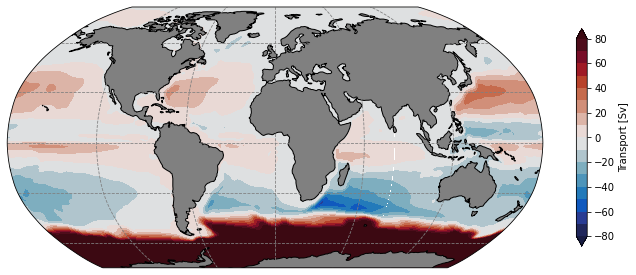

In [4]:
# Load grid for plotting
GEOLON_C = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolon_c
GEOLAT_T = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolat_t

# Initialise plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    111,
    projection=ccrs.Robinson(), # (Cartopy) Projection to use for plot
)

# Add land features and gridlines
ax.add_feature(
    cfeature.LAND,
    edgecolor='black',
    facecolor='gray',
    zorder=2,
)

ax.gridlines(color='grey', linestyle='--')

# Plot streamfunction
cf = ax.contourf(
    GEOLON_C,                      # X
    GEOLAT_T,                      # Y
    psi_g,                         # Z
    levels=np.arange(-80, 90, 10), # Number & positions of contour lines/regions
    cmap=cm.cm.balance,            # Colormap
    extend='both',                 # Determines contour colouring of values outside the levels range
    transform=ccrs.PlateCarree(),  # (Cartopy) Coordinate system your data is defined in
)

# Add colorbar
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]')

## Complete Southern Ocean

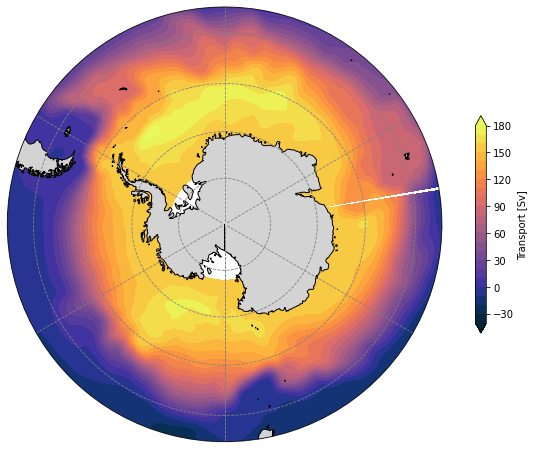

In [5]:
# Select complete Southern Ocean region
psi_so = psi_g.sel(yt_ocean=slice(-80, -45))

# Initialise plot
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(
    111,
    projection=ccrs.SouthPolarStereo(), # (Cartopy) Projection to use for plot
)
ax.set_extent(
    [-180, 180, -80, -45],
    crs=ccrs.PlateCarree(), # Coordinate system to use for setting extent
)

# Map plot boundaries to circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical',
        'land',
        '50m',
        edgecolor='black',
        facecolor='lightgray'
    ),
    zorder = 2
)

ax.gridlines(color='grey', linestyle='--')

# Plot streamfunction
cf = ax.contourf(
    psi_so['xu_ocean'],             # X
    psi_so['yt_ocean'],             # Y
    psi_so,                         # Z
    levels=np.arange(-40, 190, 10), # Number & positions of contour lines/regions
    cmap=cm.cm.thermal,             # Colormap
    extend='both',                  # Determines contour colouring of values outside the levels range
    transform=ccrs.PlateCarree(),   # (Cartopy) Coordinate system your data is defined in
)

# Add colorbar
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', shrink=0.5,)
cbar.set_label('Transport [Sv]')

## Partial Southern Ocean region

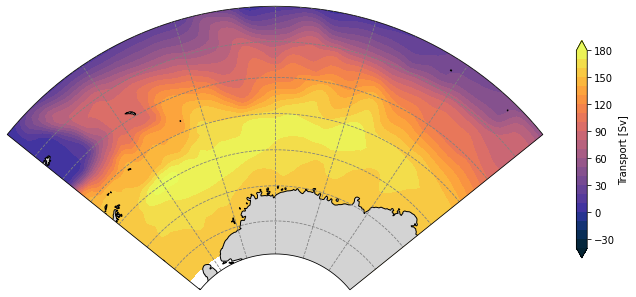

In [6]:
# Select partial Southern Ocean region
psi_re = psi_g.sel(yt_ocean=slice(-80, -45), xu_ocean=slice(-60, 60))

# Initialise plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    111,
    # (Cartopy) Projection to use for plot
    projection=ccrs.AlbersEqualArea(
        central_longitude=0,
        central_latitude=-62.5,
        standard_parallels=(-70, -50),
    ),
)
ax.set_extent(
    [-60, 60, -80, -45],
    crs=ccrs.PlateCarree(), # Coordinate system to use for setting extent
)

# Map plot boundaries to lat, lon boundaries
vertices = [(lon, -80) for lon in range(-60, 60+1, 1)] + [(lon, -45) for lon in range(60, -60-1, -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

# Add land features and gridlines
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical',            # Category of feature dataset
        'land',                # Name of feature dataset
        '50m',                 # Dataset scale
        edgecolor='black',
        facecolor='lightgray',
    ),
    zorder = 2,
)

ax.gridlines(color='grey', linestyle='--')

# Plot streamfunction
cf = ax.contourf(
    psi_re['xu_ocean'],             # X
    psi_re['yt_ocean'],             # Y
    psi_re,                         # Z
    levels=np.arange(-40, 190, 10), # Number & positions of contour lines/regions
    cmap=cm.cm.thermal,             # Colormap
    extend='both',                  # Determines contour colouring of values outside the levels range
    transform=ccrs.PlateCarree(),   # (Cartopy) Coordinate system your data is defined in
)

# Add colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]')

# Comparison against Sea Level Standard Deviation

## Loading data

In [7]:
sh = cc.querying.getvar(
    expt='1deg_jra55v13_iaf_spinup1_B1',
    variable='eta_t',
    session=session,
    start_time='2198-01-16',
    ncfile='ocean_month.nc',
).mean('time')

sl = cc.querying.getvar(
    expt='1deg_jra55v13_iaf_spinup1_B1',
    variable='sea_levelsq',
    session=session,
    start_time='2198-01-16',
    ncfile='ocean_month.nc',
).mean('time')

## Calculate sea level standard deviation

In [8]:
sla = (sl - sh**2)**0.5
sla = sla.rename('Sea level STD')
sla.attrs['long_name'] = 'Sea level standard deviation'
sla.attrs['units'] = 'm'

## Plot in Malvinas region

<a list of 25 text.Text objects>

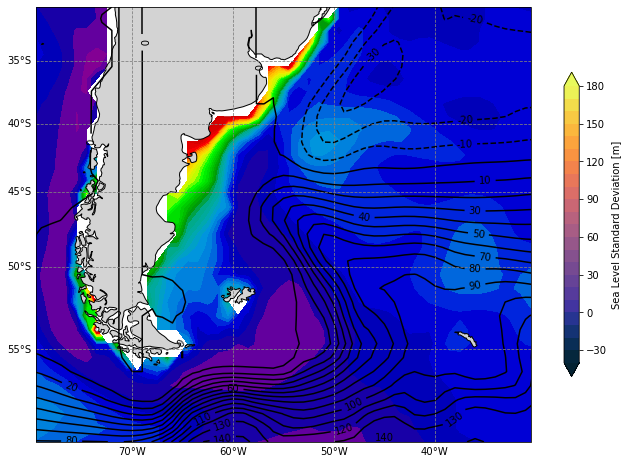

In [9]:
# Select the region
psi_ag = psi_g.sel(yt_ocean=slice(-60, -30), xu_ocean=slice(-80, -30))
sla_ag = sla.sel(yt_ocean=slice(-60, -30), xt_ocean=slice(-80, -30))

# Initialise plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    111,
    projection=ccrs.Mercator() # (Cartopy) Projection to use for plot
)
ax.set_extent(
    [sla_ag['xt_ocean'][0], sla_ag['xt_ocean'][-1], sla_ag['yt_ocean'][0], sla_ag['yt_ocean'][-1]],
    crs=ccrs.PlateCarree(), # Coordinate system to use for setting extent
)

# Add land features and gridlines
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical',
        'land',
        '50m',
        edgecolor='black',
        facecolor='lightgray',
    ),
    zorder = 2,
)

gl = ax.gridlines(draw_labels=True, color='grey', linestyle='--')
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the SLA and streamfunction
cf_sla = ax.contourf(
    sla_ag['xt_ocean'],               # X
    sla_ag['yt_ocean'],               # Y
    sla_ag,                           # Z
    levels=np.arange(0, 0.20, 0.005), # Number and positions of contour lines/regions
    cmap='nipy_spectral',             # Colormap
    extend='both',                    # Determines contour colouring of values outside the levels range
    transform=ccrs.PlateCarree(),     # (Cartopy) Coordinate system your data is defined in
)

cf_psi = ax.contour(
    psi_ag['xu_ocean'],
    psi_ag['yt_ocean'],
    psi_ag,
    colors='k',
    levels=np.arange(-30, 160, 10),
    transform=ccrs.PlateCarree(),
)

# Add colorbar and inline labels
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Sea Level Standard Deviation [m]')
ax.clabel(cf_psi, inline=1, fmt='%1.0f')